# Downloading the Data (DON'T EXECUTE THIS CODE UNLESS YOU REALLY NEED THE DATA!)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [53]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

### Import Data into this a data directory on the same level as notebooks

In [7]:
data_dir = Path("/Users/laurinlotscher/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color")

In [54]:
data_color = Path("C:/Users/mecki/Documents/UNI/HS25/DSPRO/plantvillage dataset/color")
data_grayscale = Path("C:/Users/mecki/Documents/UNI/HS25/DSPRO/plantvillage dataset/grayscale")
data_segmented = Path("C:/Users/mecki/Documents/UNI/HS25/DSPRO/plantvillage dataset/segmented")


In [55]:
counts = {
    cls.name: len(list(cls.glob("*.jpg"))) + len(list(cls.glob("*.JPG")))
    for cls in data_dir.iterdir() if cls.is_dir()
}
df = pd.DataFrame(list(counts.items()), columns=["class", "n_images"]).sort_values("n_images", ascending=False)
df.head()

NameError: name 'data_dir' is not defined

In [56]:
counts_color = {
    cls.name: len(list(cls.glob("*.jpg"))) + len(list(cls.glob("*.JPG")))
    for cls in data_color.iterdir() if cls.is_dir()    }    

counts_grayscale = {
    cls.name: len(list(cls.glob("*.jpg"))) + len(list(cls.glob("*.JPG")))
    for cls in data_grayscale.iterdir() if cls.is_dir()    }

counts_segmented = {
    cls.name: len(list(cls.glob("*.jpg"))) + len(list(cls.glob("*.JPG")))
    for cls in data_segmented.iterdir() if cls.is_dir()    }  
   
df = pd.DataFrame(list(counts_color.items()), columns=["class", "n_images"]).sort_values("n_images", ascending=False)
df_c = pd.DataFrame(list(counts_color.items()), columns=["class", "n_images"]).sort_values("n_images", ascending=False)
df_gs = pd.DataFrame(list(counts_grayscale.items()), columns=["class", "n_images"]).sort_values("n_images", ascending=False)
df_s = pd.DataFrame(list(counts_segmented.items()), columns=["class", "n_images"]).sort_values("n_images", ascending=False)

wide = (df_c.rename(columns={"n_images":"color"})
        .merge(df_gs.rename(columns={"n_images":"grayscale"}), on="class", how="outer")
        .merge(df_s.rename(columns={"n_images":"segmented"}), on="class", how="outer")
        .fillna(0)
        .sort_values(["class"])
        .reset_index(drop=True))

# optional: ensure integer counts
for col in ["color", "grayscale", "segmented"]:
    wide[col] = wide[col].astype(int)

wide.head()
df_c["n_images"].sum(), df_gs["n_images"].sum(), df_s["n_images"].sum()


(np.int64(108606), np.int64(108606), np.int64(108612))

In [ ]:
%pip install ipywidgets

In [59]:
for row in wide.itertuples():
    if row.color != row.grayscale or row.color != row.segmented:
        print("DIFFERENT COUNTS!")
        print(f"Index: {row.Index}")
        print(f"  Color: {row.color}")
        print(f"  Grayscale: {row.grayscale}")
        print(f"  Segmented: {row.segmented}")

DIFFERENT COUNTS!
Index: 12
  Color: 2766
  Grayscale: 2766
  Segmented: 2768
DIFFERENT COUNTS!
Index: 19
  Color: 2954
  Grayscale: 2954
  Segmented: 2956
DIFFERENT COUNTS!
Index: 30
  Color: 3816
  Grayscale: 3816
  Segmented: 3818


# Plot classes and count

C:\Users\mecki\AppData\Local\Temp\ipykernel_23576\3620698213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="class", x="n_images", data=df, palette="viridis")


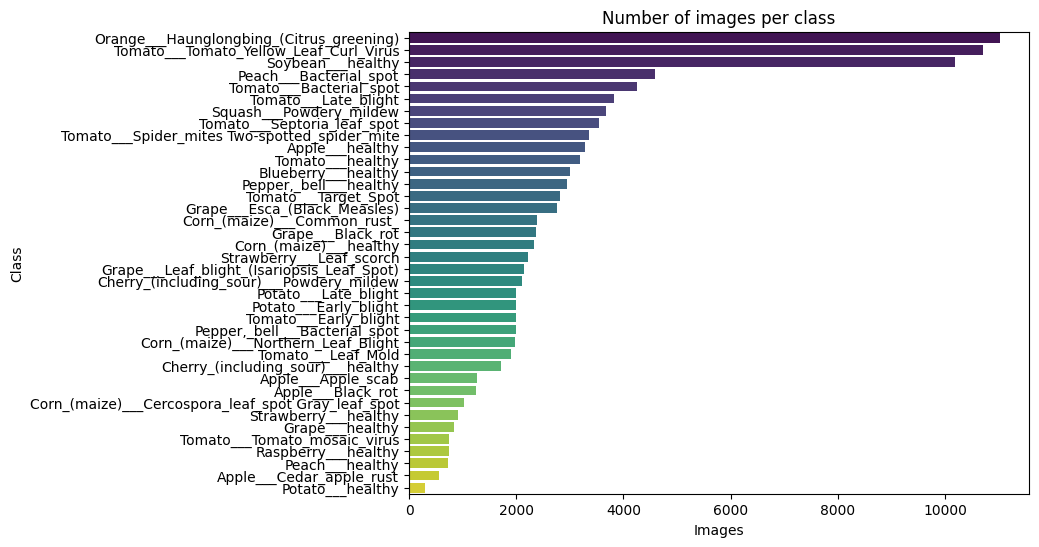

In [60]:
plt.figure(figsize=(8,6))
sns.barplot(y="class", x="n_images", data=df, palette="viridis")
plt.title("Number of images per class")
plt.xlabel("Images")
plt.ylabel("Class")
plt.show()

# Different Plants and diseases

In [61]:
df["plant"] = df["class"].apply(lambda x: x.split("___")[0])
df["condition"] = df["class"].apply(lambda x: x.split("___")[1] if "___" in x else "unknown")

df.head()

,class,n_images,plant,condition
15,Orange___Haunglongbing_(Citrus_greening),11014,Orange,Haunglongbing_(Citrus_greening)
37,Tomato___Tomato_Yellow_Leaf_Curl_Virus,10714,Tomato,Tomato_Yellow_Leaf_Curl_Virus
24,Soybean___healthy,10180,Soybean,healthy
16,Peach___Bacterial_spot,4594,Peach,Bacterial_spot
28,Tomato___Bacterial_spot,4254,Tomato,Bacterial_spot


In [62]:

df_filt = df[df["condition"] != "unknown"]

df_healthy = df[df["condition"] == "healthy"]
df_sick = df[df["condition"] != "healthy"]

cond_nplants = (
    df_filt.groupby("condition")["plant"]
           .nunique()
           .sort_values(ascending=False)
)

multi_plant_conditions = cond_nplants[cond_nplants > 1]

plants_per_condition = (
    df_filt.groupby("condition")["plant"]
           .unique()
           .loc[multi_plant_conditions.index]
)

ct = pd.crosstab(df_filt["condition"], df_filt["plant"]) 
ct_multi = ct[ct.gt(0).sum(axis=1) > 1]

# 1) Sum images per (condition, plant)
detail = (
    df_filt.groupby(["condition", "plant"], as_index=False)["n_images"]
           .sum()
           .rename(columns={"n_images": "n_images_total"})
           .sort_values(["condition", "n_images_total"], ascending=[True, False])
)

# 2) Find diseases that occur on >1 plant (consider only pairs with >0 images)
conditions_multi = (
    detail.query("n_images_total > 0")
          .groupby("condition")["plant"]
          .nunique()
)
conditions_multi = conditions_multi[conditions_multi > 1].index

# 3) Keep only those rows
detail_multi = detail[detail["condition"].isin(conditions_multi)]

multi_plant_conditions.head()
df_healthy
df_sick
plants_per_condition
ct_multi
detail_multi




,condition,plant,n_images_total
1,Bacterial_spot,Peach,4594
3,Bacterial_spot,Tomato,4254
2,Bacterial_spot,"Pepper,_bell",1994
5,Black_rot,Grape,2360
4,Black_rot,Apple,1242
9,Early_blight,Potato,2000
10,Early_blight,Tomato,2000
14,Late_blight,Tomato,3816
13,Late_blight,Potato,2000
20,Powdery_mildew,Squash,3670


In [ ]:
from ipywidgets import Dropdown, interact

cond_options = (
    detail.query("n_images_total > 0")
          .groupby("condition")["plant"]
          .nunique()
          .pipe(lambda s: s[s > 1].index.tolist())
)

def plot_condition(condition):
    sub = (detail.query("condition == @condition")
                 .sort_values("n_images_total", ascending=False))
    plt.figure(figsize=(6, 3.5))
    plt.bar(sub["plant"], sub["n_images_total"])
    plt.title(condition)
    plt.xlabel("plant")
    plt.ylabel("n_images_total")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

interact(
    plot_condition,
    condition=Dropdown(options=cond_options or sorted(detail["condition"].unique()),
                       description="Condition:")
);

interactive(children=(Dropdown(description='Condition:', options=('Bacterial_spot', 'Black_rot', 'Early_blight…

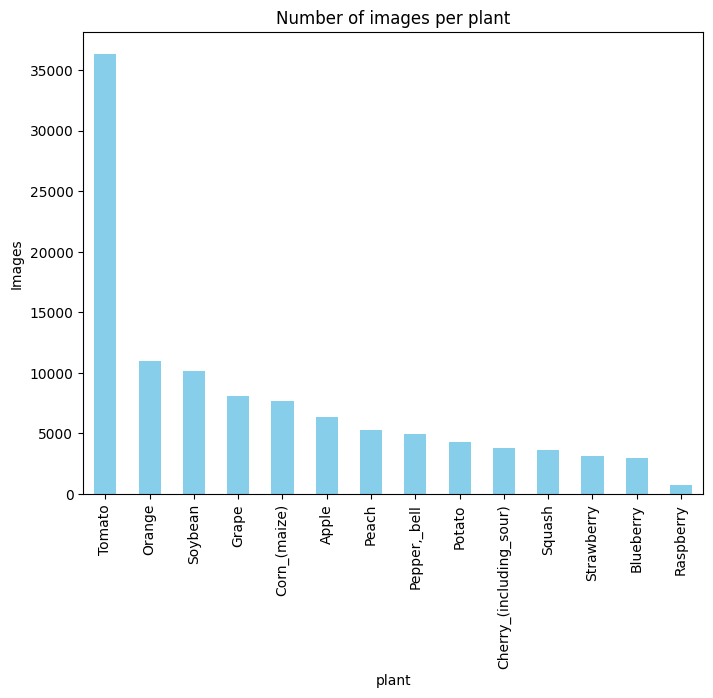

In [64]:
plant_counts = df.groupby("plant")["n_images"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))
plant_counts.plot(kind="bar", color="skyblue")
plt.title("Number of images per plant")
plt.ylabel("Images")
plt.show()

In [65]:
plant_condition_counts = df.groupby(["plant", "condition"])["n_images"].sum().reset_index()

plant_condition_counts

,plant,condition,n_images
0,Apple,Apple_scab,1260
1,Apple,Black_rot,1242
2,Apple,Cedar_apple_rust,550
3,Apple,healthy,3290
4,Blueberry,healthy,3004
5,Cherry_(including_sour),Powdery_mildew,2104
6,Cherry_(including_sour),healthy,1708
7,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,1026
8,Corn_(maize),Common_rust_,2384
9,Corn_(maize),Northern_Leaf_Blight,1970


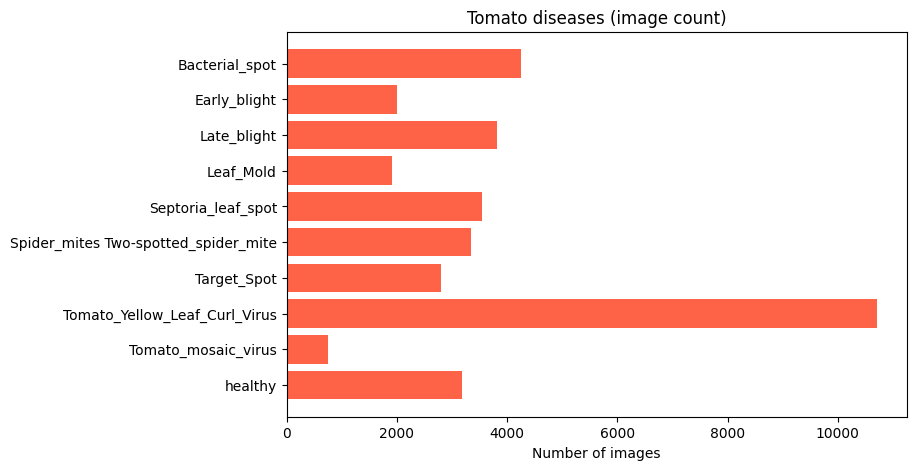

In [68]:
tomato = plant_condition_counts[plant_condition_counts["plant"]=="Tomato"]

plt.figure(figsize=(8,5))
plt.barh(tomato["condition"], tomato["n_images"], color="tomato")
plt.title("Tomato diseases (image count)")
plt.xlabel("Number of images")
plt.gca().invert_yaxis()
plt.show()

# Healthy vs Sick 

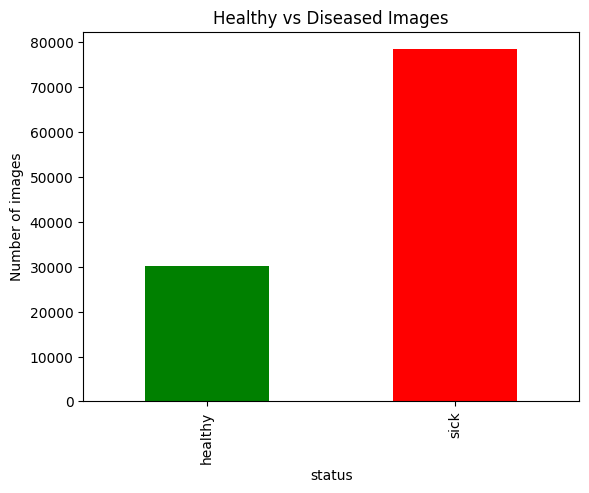

(np.int64(30166), np.int64(78440))

In [69]:
df['status'] = df['class'].apply(lambda x: 'healthy' if 'healthy' in x else 'sick')
status_counts = df.groupby("status")["n_images"].sum()


status_counts.plot(kind="bar", color=["green","red"])
plt.title("Healthy vs Diseased Images")
plt.ylabel("Number of images")
plt.show()


status_counts['healthy'], status_counts['sick']

# Class per plant

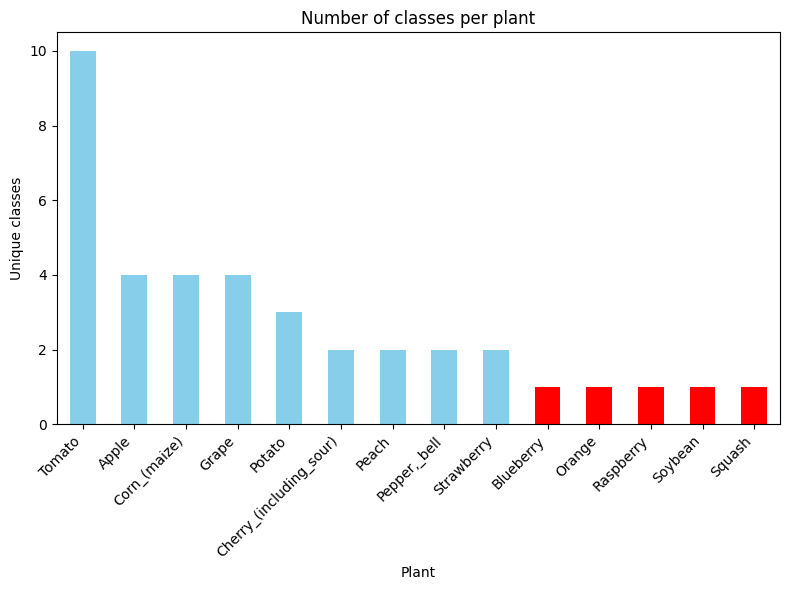

In [30]:
class_counts = (
    df.groupby("plant")["class"]
      .nunique()
      .sort_values(ascending=False)
)

colors = ["red" if n == 1 else "skyblue" for n in class_counts.values]

plt.figure(figsize=(8,6))
class_counts.plot(kind="bar", color=colors)
plt.title("Number of classes per plant")
plt.ylabel("Unique classes")
plt.xlabel("Plant")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Classes and Images count correlation

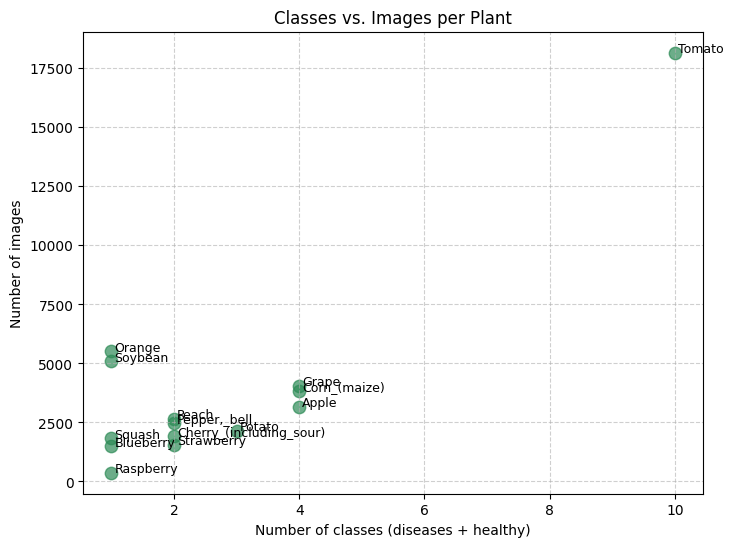

In [31]:
# aggregate per plant
per_plant = (
    df.groupby("plant")
      .agg(classes=("class", "nunique"), images=("n_images", "sum"))
      .reset_index()
)

plt.figure(figsize=(8,6))
plt.scatter(per_plant["classes"], per_plant["images"], s=80, color="seagreen", alpha=0.7)

# add labels for each plant
for _, row in per_plant.iterrows():
    plt.text(row["classes"]+0.05, row["images"], row["plant"], fontsize=9)

plt.xlabel("Number of classes (diseases + healthy)")
plt.ylabel("Number of images")
plt.title("Classes vs. Images per Plant")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Data density per class

In [32]:
# aggregate by plant
per_plant = (
    df.groupby("plant")
      .agg(classes=("class", "nunique"), images=("n_images", "sum"))
      .reset_index()
)

# calculate images per class (density)
per_plant["density"] = per_plant["images"] / per_plant["classes"]

# sort by density
per_plant_sorted = per_plant.sort_values("density", ascending=False)
per_plant_sorted.head(10)

,plant,classes,images,density
5,Orange,1,5507,5507.0
10,Soybean,1,5090,5090.0
11,Squash,1,1835,1835.0
13,Tomato,10,18159,1815.9
1,Blueberry,1,1502,1502.0
6,Peach,2,2657,1328.5
7,"Pepper,_bell",2,2474,1237.0
4,Grape,4,4062,1015.5
3,Corn_(maize),4,3852,963.0
2,Cherry_(including_sour),2,1906,953.0


/var/folders/wp/23z8rxg11fv4hsbvp2xvm3fc0000gn/T/ipykernel_15769/2337763595.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="plant", x="density", data=per_plant_sorted, palette="viridis")


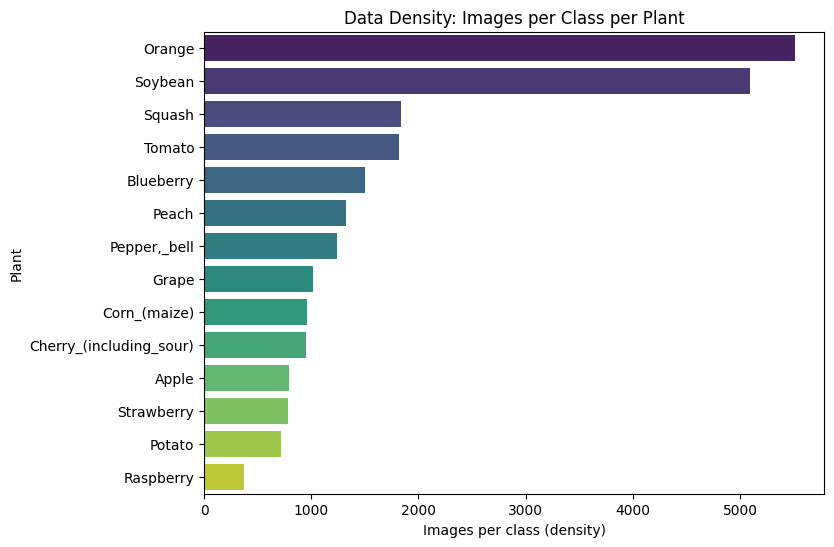

In [33]:
plt.figure(figsize=(8,6))
sns.barplot(y="plant", x="density", data=per_plant_sorted, palette="viridis")
plt.title("Data Density: Images per Class per Plant")
plt.xlabel("Images per class (density)")
plt.ylabel("Plant")
plt.show()

# Image size stats

In [23]:
sizes = []
for cls in data_dir.iterdir():
    for img_path in cls.glob("*.jpg"):
        with Image.open(img_path) as img:
            sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=["width","height"])
print(sizes_df.describe())

        width  height
count  1500.0  1500.0
mean    256.0   256.0
std       0.0     0.0
min     256.0   256.0
25%     256.0   256.0
50%     256.0   256.0
75%     256.0   256.0
max     256.0   256.0
